# load the zip file and unzip and before check the GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# import dependencies
import requests, zipfile, io
from glob import glob
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd
seed = 7
import pandas as pd
np.random.seed(seed)
import os

In [3]:
zip_file_url = 'https://github.com/karoldvl/ESC-50/archive/master.zip' # link: ESC-50 Datset

In [4]:
if not os.path.exists('sound'):
    os.makedirs('sound')

In [5]:
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('sound/')
z.close()

In [1]:
# glob('sound/ESC-50-master/audio/*')

# Define a function to covert the image based on calculate log scaled mel-spectrograms and their corresponding deltas from a sound clip.

Regarding fixed size input, we will divide each sound clip into segments of 60x41 (60 rows and 41 columns). The mel-spec and their deltas will become two channels, which we will be fed into CNN

In [7]:
# !pip install librosa
import librosa

In [8]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

def extract_features(bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for fn in tqdm(glob('sound/ESC-50-master/audio/*')):
        sound_clip,s = librosa.load(fn) # 5sec
        sound_clip   = np.concatenate((sound_clip,sound_clip),axis=None) # make it 10s
        label = fn.split("/")[-1].split("-")[-1].split(".")[0]
        for (start,end) in windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec = librosa.core.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

In [9]:
features,labels = extract_features()

100%|██████████| 2000/2000 [14:03<00:00,  2.35it/s]
/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [11]:
# label category names
df = pd.read_csv(glob('sound/ESC-50-master/meta/esc50.csv')[0])
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)
df.head()

,target,category
0,0,dog
1,1,rooster
2,2,pig
3,3,cow
4,4,frog


In [12]:
my_dict = {}
for i in range(len(df)):
    my_dict[df['target'][i]] = df['category'][i]
my_dict

{0: 'dog',
 1: 'rooster',
 2: 'pig',
 3: 'cow',
 4: 'frog',
 5: 'cat',
 6: 'hen',
 7: 'insects',
 8: 'sheep',
 9: 'crow',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 13: 'crickets',
 14: 'chirping_birds',
 15: 'water_drops',
 16: 'wind',
 17: 'pouring_water',
 18: 'toilet_flush',
 19: 'thunderstorm',
 20: 'crying_baby',
 21: 'sneezing',
 22: 'clapping',
 23: 'breathing',
 24: 'coughing',
 25: 'footsteps',
 26: 'laughing',
 27: 'brushing_teeth',
 28: 'snoring',
 29: 'drinking_sipping',
 30: 'door_wood_knock',
 31: 'mouse_click',
 32: 'keyboard_typing',
 33: 'door_wood_creaks',
 34: 'can_opening',
 35: 'washing_machine',
 36: 'vacuum_cleaner',
 37: 'clock_alarm',
 38: 'clock_tick',
 39: 'glass_breaking',
 40: 'helicopter',
 41: 'chainsaw',
 42: 'siren',
 43: 'car_horn',
 44: 'engine',
 45: 'train',
 46: 'church_bells',
 47: 'airplane',
 48: 'fireworks',
 49: 'hand_saw'}

In [13]:
seed = 4
rng = np.random.RandomState(seed)
from keras.utils import to_categorical

Using TensorFlow backend.


In [14]:
onehot_labels = to_categorical(labels,num_classes=50)

In [15]:
# Create train test Dataset

rnd_indices = np.random.rand(len(labels)) < 0.70

X_train = features[rnd_indices]
y_train = onehot_labels[rnd_indices]
X_test  = features[~rnd_indices]
y_test  = onehot_labels[~rnd_indices]

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27998, 60, 41, 2), (27998, 50), (12002, 60, 41, 2), (12002, 50))

# CNN Model

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten,InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint

In [48]:
def basemodel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(60,41,2), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='softmax'))
    # Compile model
    epochs = 25
    lrate = 0.01
    decay = lrate/epochs
#     sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
    return model


In [49]:
if not os.path.exists('model'):
    os.makedirs('model')
    
filepath="model/weights_0.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [50]:
model = basemodel()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 60, 41, 32)        608       
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 41, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 20, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 20, 64)        18496     
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 20, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 20, 64)        36928     
__________

# Training with Data Augmentation

One of the major reasons for overfitting is that we don’t have enough data to train our network. Apart from regularization, another very effective way to counter Overfitting is Data Augmentation. It is the process of artificially creating more images from the images you already have by changing the size, orientation etc of the image. It can be a tedious task but fortunately, this can be done in Keras using the ImageDataGenerator instance.

In [51]:
from keras.preprocessing.image import ImageDataGenerator

In [52]:
datagen = ImageDataGenerator(
              width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
              height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
              horizontal_flip=True,  # randomly flip images
              vertical_flip=False  # randomly flip images
          )

In [53]:
# init the batch size and epochs

'''
Note: Due to Memory Error like Buffered data was truncated after reaching the output size limit. What i did is that Save the model in for example 60th epoch and close current program and run new program and restore saved model and train model from 61 epoch to 120 epoch and 
save that and close program and repeat this work for your interested epoch For this [100,50] three times repeat 

'''
batch_size = 50
epochs = 100

In [54]:
# fit the model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              verbose=1,callbacks=callbacks_list)
 

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (27998, 60, 41, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
560/560 [==============================] - 24s 42ms/step - loss: 3.5674 - acc: 0.0626 - val_loss: 3.2620 - val_acc: 0.1219

Epoch 00001: val_acc improved from -inf to 0.12190, saving model to model/weights_0.best.hdf5
Epoch 2/100
560/560 [==============================] - 23s 40ms/step - loss: 3.0286 - acc: 0.1574 - val_loss: 2.7793 - val_acc: 0.2208

Epoch 00002: val_acc improved from 0.12190 to 0.22080, saving model to model/weights_0.best.hdf5
Epoch 3/100
560/560 [==============================] - 23s 40ms/step - loss: 2.6666 - acc: 0.2366 - val_loss: 2.5812 - val_acc: 0.2770

Epoch 00003: val_acc improved from 0.22080 to 0.27695, saving model to model/weights_0.best.hdf5
Epoch 4/100
560/560 [==============================] - 22s 40ms/step - loss: 2.3895 - acc: 0.3063 - val_loss: 2.2632 - val_acc: 0.3437

Epoch 00004: val_acc improved from 0.27695 to 0.34369, saving model to model/weights_0.best.hdf5
Epoch 5/100
560/560 [==============================] - 23s 40ms/step - 

560/560 [==============================] - 23s 40ms/step - loss: 0.8250 - acc: 0.7428 - val_loss: 1.3692 - val_acc: 0.6309

Epoch 00039: val_acc did not improve from 0.65381
Epoch 40/100
560/560 [==============================] - 22s 40ms/step - loss: 0.8150 - acc: 0.7447 - val_loss: 1.3393 - val_acc: 0.6363

Epoch 00040: val_acc did not improve from 0.65381
Epoch 41/100
560/560 [==============================] - 23s 41ms/step - loss: 0.7919 - acc: 0.7521 - val_loss: 1.2517 - val_acc: 0.6531

Epoch 00041: val_acc did not improve from 0.65381
Epoch 42/100
560/560 [==============================] - 22s 40ms/step - loss: 0.7903 - acc: 0.7535 - val_loss: 1.2711 - val_acc: 0.6480

Epoch 00042: val_acc did not improve from 0.65381
Epoch 43/100
560/560 [==============================] - 22s 39ms/step - loss: 0.7793 - acc: 0.7569 - val_loss: 1.1919 - val_acc: 0.6661

Epoch 00043: val_acc improved from 0.65381 to 0.66606, saving model to model/weights_0.best.hdf5
Epoch 44/100
560/560 [=========

560/560 [==============================] - 22s 39ms/step - loss: 0.5556 - acc: 0.8249 - val_loss: 1.1243 - val_acc: 0.7099

Epoch 00081: val_acc improved from 0.70988 to 0.70988, saving model to model/weights_0.best.hdf5
Epoch 82/100
560/560 [==============================] - 22s 39ms/step - loss: 0.5521 - acc: 0.8284 - val_loss: 1.2078 - val_acc: 0.6921

Epoch 00082: val_acc did not improve from 0.70988
Epoch 83/100
560/560 [==============================] - 22s 39ms/step - loss: 0.5516 - acc: 0.8278 - val_loss: 1.1587 - val_acc: 0.7036

Epoch 00083: val_acc did not improve from 0.70988
Epoch 84/100
560/560 [==============================] - 22s 39ms/step - loss: 0.5477 - acc: 0.8291 - val_loss: 1.1231 - val_acc: 0.7086

Epoch 00084: val_acc did not improve from 0.70988
Epoch 85/100
560/560 [==============================] - 22s 39ms/step - loss: 0.5486 - acc: 0.8297 - val_loss: 1.1407 - val_acc: 0.7041

Epoch 00085: val_acc did not improve from 0.70988
Epoch 86/100
560/560 [=========

Note: Due to Memory Error like Buffered data was truncated after reaching the output size limit.
What i did is that Save the model in for example 60th epoch and close current program and run new program and restore saved model and train model from 61 epoch to 120 epoch and save that and close program and repeat this work for your interested epoch 
For this [100,50] three times repeat 


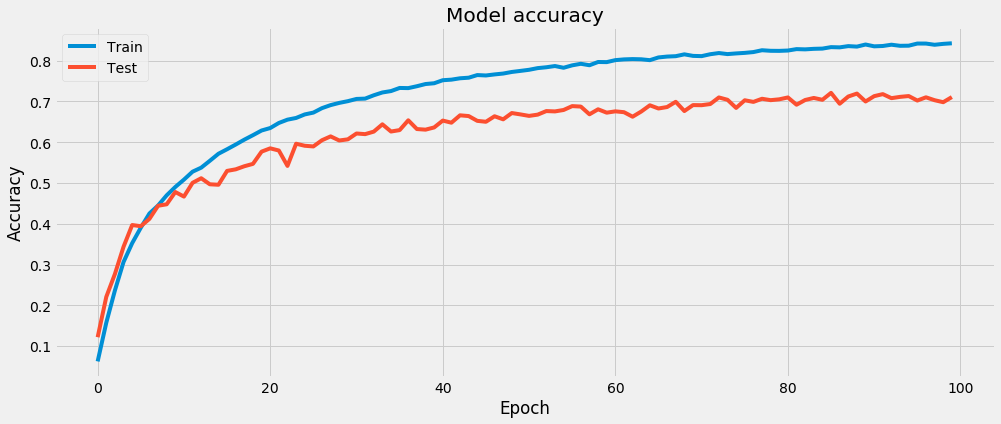

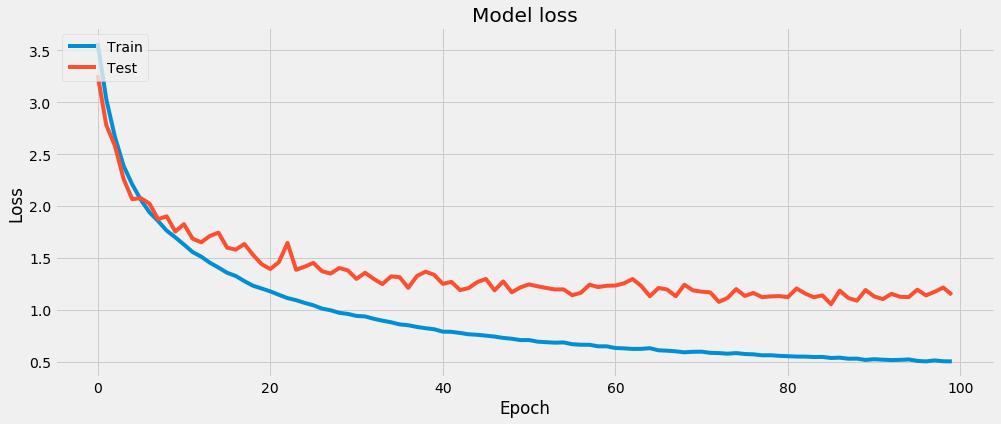

In [55]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Plot training & validation accuracy values
plt.figure(figsize=(15,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
# evaluate model
model.evaluate(X_test, y_test)

12002/12002 [==============================] - 1s 111us/step


[1.1470031869786914, 0.71079820029995]

# Classification Report and Confusion Matrix

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
y_pred = model.predict_classes(X_test)

In [59]:
target_name = np.array(df['category'])

In [60]:
print(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_name))

                  precision    recall  f1-score   support

             dog       0.76      0.76      0.76       242
         rooster       0.76      0.42      0.54       248
             pig       0.82      0.62      0.71       253
             cow       0.74      0.69      0.71       233
            frog       0.92      0.86      0.89       237
             cat       0.64      0.63      0.64       236
             hen       0.72      0.68      0.70       219
         insects       0.73      0.79      0.76       230
           sheep       0.73      0.76      0.74       243
            crow       0.88      0.72      0.79       235
            rain       0.80      0.94      0.87       220
       sea_waves       0.64      0.88      0.74       242
  crackling_fire       0.88      0.77      0.82       247
        crickets       0.89      0.94      0.91       245
  chirping_birds       0.90      0.67      0.77       232
     water_drops       0.76      0.50      0.60       250
            w

In [ ]:
import seaborn as sns
cn_matrix = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
plt.figure(figsize = (20,20))
sns.heatmap(cn_matrix, annot=True)